# I. The Hadamard Test

In [2]:
from qiskit import QuantumCircuit
from qiskit.providers.basic_provider import BasicSimulator
from qiskit.visualization import plot_histogram
from qiskit.visualization import plot_bloch_vector
from qiskit.primitives import BackendSampler
from qiskit.quantum_info import SparsePauliOp

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from numpy import pi
import numpy as np
import matplotlib.pyplot as plt

## Introduction to Qubits

Quantum bits, more commonly referred to as Qubits, are particles such as photons or electrons used as "bits" in Quantum computation. Qubits function quite differently than classical bits because of a phenomenon called superposition (which we will explore shortly), a phenomenon classical systems do not experience. This difference requires a new computational approach to setups and circuits to perform calculations.

Similar to classical bits, qubits have two distinct states that a Quantum Computer can read: 0 and 1. One state represents "spin up" and the other "spin down". We represent these states as $|0\rangle$ and $|1\rangle$ respectively. The $|\rangle$ around each state is called a "ket" where each state is pronounced "ket $0$" and "ket $1$". This is called dirac notation, sometimes reffered to as bra-ket notation, and is most commonly how quantum states are represented.

These states represent an ortho-normal basis meaning they are of unit length and orthogonal to eachother. This basis is called the Z-Basis (see single qubit gates below for more information).

Below $|0\rangle$ represents a qubit with spin up, and $|1\rangle$ represents a qubit with spin down.


$$|0\rangle =  \begin{pmatrix}1\\0\end{pmatrix}$$

$$|1\rangle =  \begin{pmatrix}0\\1\end{pmatrix}$$

We can see that the $|0\rangle$ state has a $1$ probability of being $0$, and a $0$ probability of being 1 and vice versa for the |$1\rangle$ state

### Superposition
Superposition is the idea that something can be in combination states at the same time.
Since qubits in a Quantum Computer are in an enviroment with very little outside forces/particles, we can put particles into a superposition of the states.
An example of a superposition state of $|0\rangle$ and $|1\rangle$ is the $|+\rangle$ state.

$$|+\rangle = \frac{1}{\sqrt{2}}(|0\rangle + |1\rangle) = \frac{1}{\sqrt{2}} \begin{pmatrix}1\\1\end{pmatrix}$$

States like the $|+\rangle$ state give qubits an advantage over classical bits, allowing much more complex calculations in far fewer steps. In theory, this allows Quantum Computers to be able to construct and perform algorthims that are much faster than classical computing methods.

### Bloch Sphere
A common technique for visualizing superposition states is the bloch sphere. The state shown below is $|0\rangle$.

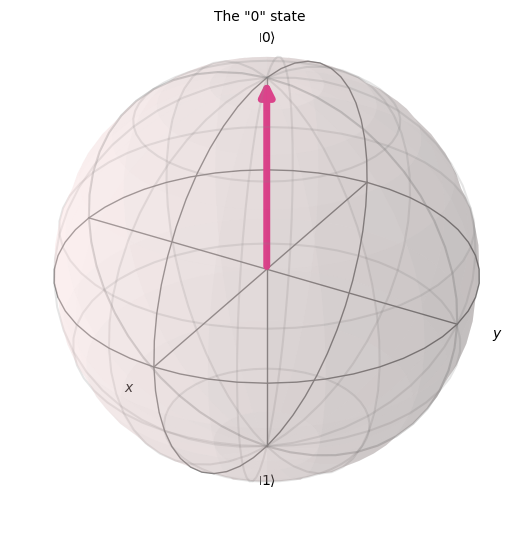

In [10]:
plot_bloch_vector([0,0,1], title='The 0 state')

### Measurement
But, you might be asking, what would happen if we were to measure a particle in superposition? Well, when a particle that is put into superposition is measured, it collapses in to one of the states it is in a combination of. For example if we were to take the $|+\rangle$ state above and tried to measure it sometimes we would get $0$ and other times we would get $1$ with certain probabilities. To calculate these probabilities we first need to find the coeffiecent in front of the state we want to measure. We can do an inner product of the hermitian (also called dagger operation) of the state you want to measure with the current state of the particle. The Hermitian of a state is equivalent to the conjugate transpose of that state. The Hermitian of a generic state can be written in dirac notation as $\langle \psi|$ where this "backwards" ket is pronounced "bra psi". This is where the name "bra-ket" notation comes from.

For example, lets say I wanted to see what fraction of the time I will measure $|0\rangle$ from the $|+\rangle$ state. Since $|0\rangle$ and $|1\rangle$ form a basis for the states of the qubits, the inner product of two of the same states will be $1$, and the inner product of two different states will be $0$. By performing the same calculation in dirac notation and alternatively with linear algebra, we can see how they are equivalent processes and we end up with the same result.

Dirac notation:
$$\langle 0|+\rangle = \langle 0|\left(\frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)\right) = \frac{1}{\sqrt{2}}(\langle 0|0\rangle + \langle 0|1\rangle) = \frac{1}{\sqrt{2}} (1 + 0) = \frac{1}{\sqrt{2}}$$

Linear Algebra:
$$\langle 0|+\rangle = \begin{pmatrix}1&0\end{pmatrix}\frac{1}{\sqrt{2}}\begin{pmatrix}1\\1\end{pmatrix} = \frac{1}{\sqrt{2}}(1 + 0) = \frac{1}{\sqrt{2}}$$

This coefficient that we get out of the inner product has the possibility to be a complex number which wouldn't make physical sense for a probability. To this end we multiply the coefficient by its complex conjugate to find the true probability.

$$\mathbb{P}(|0\rangle) = ||\langle 0|+\rangle|| = \langle 0|+\rangle \overline{\langle 0|+\rangle} = \frac{1}{\sqrt{2}}\frac{1}{\sqrt{2}} = \frac{1}{2}$$

This means that $50\%$ of the time we will measure $|0\rangle$ from $|+\rangle$. <b> For any state $|\psi\rangle$ the probability of getting $|0\rangle$ plus the probability of getting $|1\rangle$ must be equal to 1 </b>, because putting a particle into superposition doesn't create or destroy parts of the particle. 

In order to find a probability of a particle being in a state, this always requires we multiply it by its complex conjugate. Therefore, there can be states that are equivalent to eachother even though they have different constants in front of them when measured in a certain basis. For example, $e^{\pi/4}|0\rangle \equiv |0\rangle$ in the $Z$-Basis. This means that $e^{\pi/4}|0\rangle$ and $|0\rangle$ have a different global phase, but when measuring them there will be no distinction. <b>Global Phase doesn't affect the probabilities of measurement.</b>

## Single Qubit Gates
To perform calculation on qubits we need to setup the qubits to be in the correct states before we have them interact with eachother.

### X-gate
The $X$-gate is a bit flip, which is a $180^{\circ}$ rotation around the $x$-axis on the bloch sphere.
$$X = \begin{pmatrix}0&1\\1&0\end{pmatrix}$$
$$X|0\rangle = \begin{pmatrix}0&1\\1&0\end{pmatrix}\begin{pmatrix}1\\0\end{pmatrix} = \begin{pmatrix}0\\1\end{pmatrix} = |1\rangle$$
$$X|1\rangle = \begin{pmatrix}0&1\\1&0\end{pmatrix}\begin{pmatrix}0\\1\end{pmatrix} = \begin{pmatrix}1\\0\end{pmatrix} = |0\rangle$$
The $X$-Basis is $|+\rangle$ and $|-\rangle$ (since they are eigenvectors of the $X$-gate)

### Z-gate
The $Z$-gate is a phase-flip, which is a $180^{\circ}$ rotation around the $z$-axis on the bloch sphere.
$$Z = \begin{pmatrix}1&0\\0&-1\end{pmatrix}$$
$$Z|0\rangle = \begin{pmatrix}1&0\\0&-1\end{pmatrix}\begin{pmatrix}1\\0\end{pmatrix} = \begin{pmatrix}1\\0\end{pmatrix} = |0\rangle$$
$$Z|1\rangle = \begin{pmatrix}1&0\\0&-1\end{pmatrix}\begin{pmatrix}0\\1\end{pmatrix} = \begin{pmatrix}0\\-1\end{pmatrix} = -|1\rangle$$
The $Z$-Basis is $|0\rangle$ and $|1\rangle$ (since they are eigenvectors of the $Z$-gate) 

### Y-gate
The $Y$-gate is a phase-flip and a bit flip, which is a $180^{\circ}$ rotation around the $y$-axis on the bloch sphere.
$$Y = \begin{pmatrix}0&-i\\i&0\end{pmatrix}$$
$$Y|0\rangle = \begin{pmatrix}0&-i\\i&0\end{pmatrix}\begin{pmatrix}1\\0\end{pmatrix} = \begin{pmatrix}0\\i\end{pmatrix} = i|1\rangle$$
$$Y|1\rangle = \begin{pmatrix}0&-i\\i&0\end{pmatrix}\begin{pmatrix}0\\1\end{pmatrix} = \begin{pmatrix}-i\\0\end{pmatrix} = -i|0\rangle$$
The $Z$-Basis is $|i\rangle$ and $|-i\rangle$ (since they are eigenvectors of the $Z$-gate) (also written explicity out below)

$$|i\rangle = \frac{1}{\sqrt{2}}(|0\rangle + i|1\rangle) = \frac{1}{\sqrt{2}} \begin{pmatrix}1\\i\end{pmatrix}$$
$$|-i\rangle = \frac{1}{\sqrt{2}}(|0\rangle - i|1\rangle) = \frac{1}{\sqrt{2}} \begin{pmatrix}1\\-i\end{pmatrix}$$

### "I"-Gate
The identity gate does nothing to the state that is put into it. 
$$I = \begin{pmatrix}1&0\\0&1\end{pmatrix}$$
$$I|0\rangle = \begin{pmatrix}1&0\\0&1\end{pmatrix}\begin{pmatrix}1\\0\end{pmatrix} = \begin{pmatrix}1\\0\end{pmatrix} = |0\rangle$$
$$I|1\rangle = \begin{pmatrix}1&0\\0&1\end{pmatrix}\begin{pmatrix}0\\1\end{pmatrix} = \begin{pmatrix}0\\1\end{pmatrix} = |1\rangle$$

## Control Gates
Control Gates are gates that change one qubit based off of the state of another. To determine what they will look like as matrices we must first discuss how to tensor products.
### Tensor Products
Tensor products are a way to linearly combine different objects to represent independent combinations of them. For example say we wanted to figure out how to represent the state $|0\rangle|1\rangle$ as a vector.
$$ |0\rangle|1\rangle = \begin{pmatrix}1\\0\end{pmatrix} \otimes \begin{pmatrix}0\\1\end{pmatrix} = \begin{pmatrix}1 \begin{pmatrix}0\\1\end{pmatrix} \\0 \begin{pmatrix}0\\1\end{pmatrix} \end{pmatrix} = \begin{pmatrix}0\\1\\0\\0\end{pmatrix} $$

Another example is suppose we have a circuit shown below and we want to represent what will happen to the qubits agter they go throught the circuit.

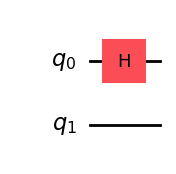

In [6]:
qc = QuantumCircuit(2)
qc.h(0)
qc.draw('mpl')

We can do this via a tensor product with $H \otimes I$
$$H \otimes I = \frac{1}{\sqrt{2}} \begin{pmatrix}1&1\\1&-1\end{pmatrix} \otimes \begin{pmatrix}1&0\\0&1\end{pmatrix} =
\frac{1}{\sqrt{2}} \begin{pmatrix}1 \begin{pmatrix}1&0\\0&1\end{pmatrix}&1 \begin{pmatrix}1&0\\0&1\end{pmatrix}\\1 \begin{pmatrix}1&0\\0&1\end{pmatrix}&-1 \begin{pmatrix}1&0\\0&1\end{pmatrix}\end{pmatrix} =  \begin{pmatrix}1&0&1&0\\0&1&0&1\\1&0&-1&0\\0&1&0&-1\end{pmatrix}$$

Now we can plug in any initial state we want to find the final state.

### $CNOT_{01}$-Gate
One controlled gate is the $CNOT_{01}$ gate (can also be written as $CX_{01}$). The first number of the subscript is the target qubit's number and the second number is the control qubit's number.
$$CNOT_{01}|00\rangle = \begin{pmatrix}1&0&0&0 \\ 0&1&0&0 \\ 0&0&0&1 \\ 0&0&1&0 \end{pmatrix}\begin{pmatrix}1\\0\\0\\0\end{pmatrix} = \begin{pmatrix}1\\0\\0\\0\end{pmatrix} = |00\rangle$$
$$CNOT_{01}|01\rangle = \begin{pmatrix}1&0&0&0 \\ 0&1&0&0 \\ 0&0&0&1 \\ 0&0&1&0 \end{pmatrix}\begin{pmatrix}0\\1\\0\\0\end{pmatrix} = \begin{pmatrix}1\\0\\0\\0\end{pmatrix} = |01\rangle$$
$$CNOT_{01}|10\rangle = \begin{pmatrix}1&0&0&0 \\ 0&1&0&0 \\ 0&0&0&1 \\ 0&0&1&0 \end{pmatrix}\begin{pmatrix}0\\0\\1\\0\end{pmatrix} = \begin{pmatrix}0\\0\\0\\1\end{pmatrix} = |11\rangle$$
$$CNOT_{01}|11\rangle = \begin{pmatrix}1&0&0&0 \\ 0&1&0&0 \\ 0&0&0&1 \\ 0&0&1&0 \end{pmatrix}\begin{pmatrix}0\\0\\0\\1\end{pmatrix} = \begin{pmatrix}0\\0\\1\\0\end{pmatrix} = |10\rangle$$

### Hadamard-Gate
The Hadamard Gate puts an individual qubit into superposition.

$$H=\frac{1}{\sqrt{2}}\begin{pmatrix} 1 & 1\\1 & -1\end{pmatrix}$$

Let's look at the affect of applying a Hadamard gate to a state $|0\rangle$:

$$|0\rangle  = \begin{pmatrix}1\\0\end{pmatrix} \qquad \qquad H=\frac{1}{\sqrt{2}}\begin{pmatrix} 1 & 1\\1 & -1\end{pmatrix}$$

$$\xrightarrow{H} \frac{1}{\sqrt{2}}\begin{pmatrix} 1 & 1\\1 & -1\end{pmatrix} \begin{pmatrix}1\\0\end{pmatrix} = \frac{1}{\sqrt{2}}\begin{pmatrix}1\\1\end{pmatrix} = \begin{pmatrix}\frac{1}{\sqrt{2}}\\\frac{1}{\sqrt{2}}\end{pmatrix}$$

Moving back into dirac notation we can see the affect of applying the Hadamard gate to the $|0\rangle$ state gives:

$$\frac{1}{\sqrt{2}}\left(|0\rangle + |1\rangle\right)$$

This shows how the Hadmard gate can turn the $|0\rangle$ state into the $|+\rangle$ state where the magnitude of the probability of measuring $1$ or $0$ is the same and they are both positive. Looking at the affect of the same gate on the $|1\rangle$ state:

$$|1\rangle  = \begin{pmatrix}0\\1\end{pmatrix} \qquad \qquad H=\frac{1}{\sqrt{2}}\begin{pmatrix} 1 & 1\\1 & -1\end{pmatrix}$$
$$\xrightarrow{H} \frac{1}{\sqrt{2}}\begin{pmatrix} 1 & 1\\1 & -1\end{pmatrix} \begin{pmatrix}0\\1\end{pmatrix} = \frac{1}{\sqrt{2}}\begin{pmatrix}1\\-1\end{pmatrix} = \begin{pmatrix}\frac{1}{\sqrt{2}}\\-\frac{1}{\sqrt{2}}\end{pmatrix}$$

Again, returning to dirac notation we see that this becomes:

$$\frac{1}{\sqrt{2}}\left(|0\rangle - |1\rangle\right)$$

The gate again transforms the state into superposition but this time brings it to the $|-\rangle$ state where the magnitude of the probabilities are still the same but they are now a difference instead of a sum. Note that the total probability of each superposition is still $1$:

$$\left(\frac{1}{\sqrt{2}}\right)^{2} + \left(\frac{1}{\sqrt{2}}\right)^{2} = 1 \qquad \qquad \left(\frac{1}{\sqrt{2}}\right)^{2} + \left(-\frac{1}{\sqrt{2}}\right)^{2} = 1$$

## Eigenvalues and Eigenvectors
Something that is somewhat important to understand is Eigenvalues and Eigenvectors since every qubit gate can be represented as matrix. Eigenvalues and Eigenvector solve the below equation. ($\lambda$ represents the eigenvalue and $|\Psi\rangle$ represents the eigenvector.)
$$U|\Psi\rangle = \lambda|\Psi\rangle$$

This equations effectively says that a Gate operating on one of its eigenvectors is equivent to that eigenvector times its eigenvalue. Something interesting you can do with eigenvalues and eigenvectors is decompose a matrix into a couple of more mangeable matricies. This decomposition is called spectral decomposition. (A small derivation is shown below.)
$$U|\Psi\rangle = \lambda|\Psi\rangle \implies U\Psi = \Psi\Lambda \implies U = \Psi\Lambda\Psi^{-1} \implies U = \Psi\Lambda\Psi^{T}$$

The last step could be instead the $\dagger$ operation

Where $\Lambda = I|\lambda\rangle$ (with $|\lambda\rangle$ representing all the eigenvalues put into a vector) and $\Psi$ representing a matrix of all the eigenvectors as columns (arranged in similar ordering to the $\Lambda$ matrix). The final step of the derivation is only allowed if each eigenvector is normalized (aka $\langle \psi | \psi \rangle = 1$). Note you can only do this decomposition if you havea square matrix (since the number of eigenvalues must be equal to size of each eigenvector)

## Quantum Phase Estimation (QPE): The Problem Setup

The goal of quantum phase estimation is to estimate the eigenvalues of a given known unitary operator $U$ with a given state $|\psi\rangle$. Using the computed eigenvalue we can calculate the phase. Phase estimation is often a subproblem where we use the quantum phase estimation procedure as a part in some larger more classically applicable problem. 

Since $U$ is an square matrix we can spectral decompose it into the form $U = \Psi\Lambda\Psi^\dagger$ where $|\psi_1\rangle,\dots,|\psi_N\rangle$ are unit length eigenvectors and $\lambda_1 = e^{i\theta_1}, \dots, \lambda_N = e^{i\theta_N}$ where $0\leq \theta_N \leq 2\pi$.

$$U = \begin{pmatrix}|\psi_1\rangle & \cdots & |\psi_N\rangle\end{pmatrix}
      \begin{pmatrix}
      \lambda_1&0&0&\cdots&0\\
      0&\lambda_2&0&&0\\
      0&0&\lambda_3&&0\\
      \vdots &&&\ddots&\vdots\\
      0&0&0&\cdots&\lambda_N\\
      \end{pmatrix}
      \begin{pmatrix}\langle \psi_1| & \cdots & \langle \psi_N|\end{pmatrix}
      $$

This can be rewritten as:

$$U = \sum_{k=1}^{N}\lambda_k|\psi_k\rangle\langle\psi_k|$$

This is a different way to write the spectral decomposition of $U$. Since we know each vector $|\psi_k\rangle$ is part of an orthonormal basis, we can say that each vector $|\psi_k\rangle$ is an eigenvector of $U$ having eigenvalue $\lambda_k$:

$$U|\psi_k\rangle = \lambda_k|\psi_k\rangle = e^{i\theta_k}|\psi_k\rangle, \quad 0\leq \theta_k \leq 2\pi$$

It is important to note that this is not neccessarily how $U$ works for an arbitrary vector. But because we know there is an ortho-normal basis of eigenvectors, if $U$ is multiplied to any $|\psi_k\rangle$, using the ortho-normality of the vectors we are left with all terms being $0$ except for the final $\lambda_k$ giving us the equation above.

The eigenvalue $\lambda_k$ is also often written as $\lambda_k = e^{i2\pi\varphi_k}$ where $0\leq \varphi_k \leq 1$. We are given a unitary operator $U$, and $|\psi\rangle$ and eigenvector of $U$. We can now set up the phase estimation problem as follows:

$$U|\psi\rangle = e^{i2\pi\varphi}|\psi\rangle, \quad \varphi \in [0,1)$$

We can think of this exponent "$i2\pi\varphi$" as the location of a point around the complex unit circle. The real number $\varphi$ is effectively rotating this point up to $i2\pi \text{ rad}$ as $\varphi$ goes from $0$ to $1$. Ensuring we are including $0$ and not $1$ for the range of $\varphi$ guarantees that we can represent every point on the complex unit circle with a unique value of $\varphi$. This is because $i0$ and $i2\pi\text{ rad}$ are the same position on the complex unit circle.

Eigenvectors form a basis and unit length eigenvectors form an orthnormal basis.

## Hadamard Test

The simplest way to estimate $\varphi$ with a quantum computer is to use the Hadamard test. This test is a very useful tool for estimating the expectation value of a unitary operator with respect to some state, i.e., $\langle \psi|U|\psi\rangle$. Our unitary operator $U$ is not generally a hermitian matrix meaning its eigenvalues can be complex and not just real. Therefore this does not correspond to the measurement of a physical observable, which means we need to encode it into something physical we can measure. For this method, we measure the real and imaginary part of the expectation value seperately.

Lets start by looking at the the real and imaginary Hadamard Test Circuits.

LEARN HOW TO MAKE A GENERIC CIRCUIT FOR THIS

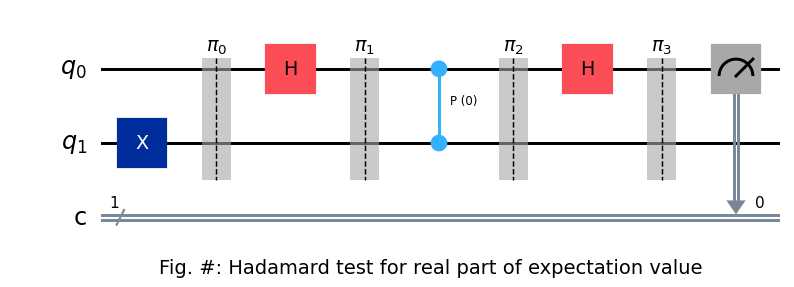

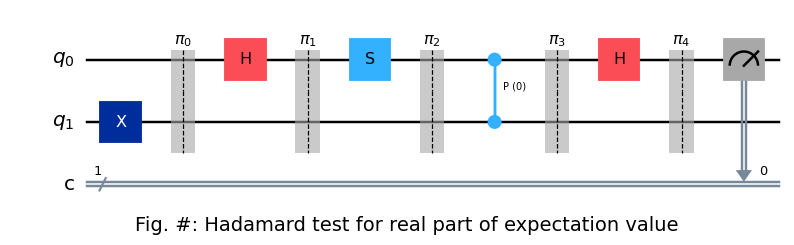

In [8]:
qc = re_circuit(0)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot()
ax.text(0, -2.75, 'Fig. #: Hadamard test for real part of expectation value', size=14)

qc.draw('mpl', ax=ax)

qc = im_circuit(0)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot()
ax.text(0, -2.75, 'Fig. #: Hadamard test for real part of expectation value', size=14)

qc.draw('mpl', ax=ax)

The unitary operator $U$ will apply the phase of $|\psi\rangle$ onto $q_0$

### Proof

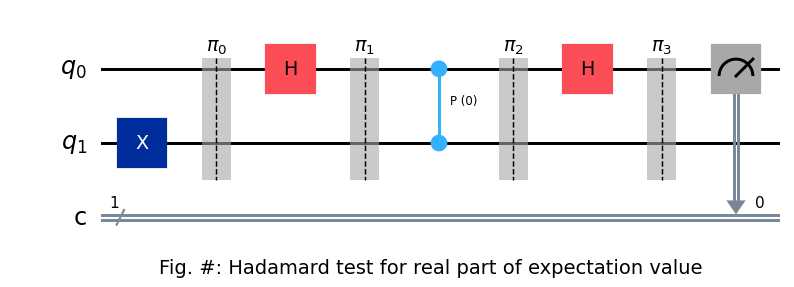

In [10]:
qc = re_circuit(0)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot()
ax.text(0, -2.75, 'Fig. #: Hadamard test for real part of expectation value', size=14)

qc.draw('mpl', ax=ax)

The intial state of our circuit can be represented as

$$|\pi_0\rangle = |0\rangle \otimes |\psi\rangle = |0\rangle|\psi\rangle = \begin{pmatrix}1 \\ 0\end{pmatrix}|\psi\rangle$$

We then apply the Hadamard gate to the control qubit transforming it to the $|+\rangle$ state

$$|\pi_1\rangle 
= (H \otimes I) \cdot (|0\rangle|\psi\rangle)
= H|0\rangle I|\psi\rangle
= \frac{1}{\sqrt{2}}\begin{pmatrix} 1 & 1\\1 & -1\end{pmatrix}\begin{pmatrix}1\\0\end{pmatrix}|\psi\rangle
= \frac{1}{\sqrt{2}}\begin{pmatrix} (1\cdot 1) + (1\cdot 0) \\(1\cdot 1) + (-1\cdot 0) \end{pmatrix}|\psi\rangle 
= \frac{1}{\sqrt{2}}\begin{pmatrix} 1\\1 \end{pmatrix}|\psi\rangle
= \frac{1}{\sqrt{2}}\left(|0\rangle + |1\rangle \right)|\psi\rangle 
= |+\rangle|\psi\rangle$$

Next the controlled-unitary operator is performed resulting in the following state rotating $q_0$ equivent to the eigenvalue of $|\psi\rangle$

$$|\pi_2\rangle 
= CU|+\rangle|\psi\rangle
= \frac{1}{\sqrt{2}}|0\rangle|\psi\rangle + \frac{1}{\sqrt{2}} |1\rangle U|\psi\rangle 
= \frac{1}{\sqrt{2}} \begin{pmatrix} 1 & 0\\0 & e^{i\theta}\end{pmatrix}\begin{pmatrix} 1\\1 \end{pmatrix}|\psi\rangle 
= \frac{1}{\sqrt{2}} \begin{pmatrix} (1\cdot 1) + (0\cdot 1) \\ (0\cdot 1) + (1\cdot e^{i\theta})\end{pmatrix}|\psi\rangle 
= \frac{1}{\sqrt{2}} \begin{pmatrix} 1\\ e^{i\theta}\end{pmatrix}|\psi\rangle 
= \frac{1}{\sqrt{2}}\left(|0\rangle + e^{i\theta}|1\rangle \right)|\psi\rangle$$

Finally, we apply the second Hadamard gate to the circuit leaving us with the state

$$|\pi_3\rangle = H\frac{1}{\sqrt{2}}\left(|0\rangle + e^{i\theta}|1\rangle \right)|\psi\rangle = \frac{1}{2}\begin{pmatrix} 1 & 1\\1 & -1\end{pmatrix}\begin{pmatrix} 1\\ e^{i\theta}\end{pmatrix}|\psi\rangle = \frac{1}{2}\begin{pmatrix} (1\cdot 1) + (1\cdot e^{i\theta}) \\(1\cdot 1) + (-1\cdot e^{i\theta})\end{pmatrix}|\psi\rangle = \frac{1}{2}\begin{pmatrix} 1 + e^{i\theta} \\1 - e^{i\theta}\end{pmatrix}|\psi\rangle = \left(\frac{1+e^{i\theta}}{2}|0\rangle + \frac{1-e^{i\theta}}{2}|1\rangle\right)|\psi\rangle$$

For simplicity in calculating the probabilities, this can also be represented as matrix operations on $|\psi\rangle$
$$|0\rangle\frac{I+U}{2}|\psi\rangle + |1\rangle\frac{I-U}{2}|\psi\rangle$$

Since we know the probability of a quantum state comes from the probability amplitude times its complex conjugate, we can calculate the final probablities. We will first look at the probability of measuring the qubit $0$ to be in the $|0\rangle$ state.

$$p_{\text{Re}}(|0\rangle) 
= |\langle 0|\pi_3\rangle|^2 
=\left| \langle 0|0\rangle\frac{I+U}{2}|\psi\rangle + \langle0|1\rangle\frac{I-U}{2}|\psi\rangle\right|^2 
= \left|\frac{I+U}{2}|\psi\rangle\right|^2 
= \frac{\langle \psi|(I+U^{\dagger})(I+U)|\psi\rangle}{4} 
= \frac{\langle \psi|(I+U+U^{\dagger}+U^{\dagger}U)|\psi\rangle}{4}$$

If we now take a similar process for the probability of measuring qubit $0$ to be in the $|1\rangle$ state, we get the following

$$p_{\text{Re}}(|1\rangle) 
= |\langle 1|\pi_3\rangle|^2 
= \left| \langle 1|0\rangle\frac{I+U}{2}|\psi\rangle + \langle 1|1\rangle\frac{I-U}{2}|\psi\rangle\right|^2 
= \left|\frac{I-U}{2}|\psi\rangle\right|^2 
= \frac{\langle \psi|(I-U^{\dagger})(I-U)|\psi\rangle}{4} 
= \frac{\langle \psi|(I-U-U^{\dagger}+U^{\dagger}U)|\psi\rangle}{4}$$

Using the fact that $U^\dagger U = I$, these probabilites can be simplified further

$$p_{\text{Re}}(|0\rangle) =  \frac{\langle \psi|(I+U+U^{\dagger}+U^{\dagger}U)|\psi\rangle}{4} = \frac{\langle \psi|(2I+U+U^{\dagger})|\psi\rangle}{4} = \frac{2 + \langle \psi|(U+U^{\dagger})|\psi\rangle}{4}$$

$$p_{\text{Re}}(|1\rangle) =  \frac{\langle \psi|(I-U-U^{\dagger}+U^{\dagger}U)|\psi\rangle}{4} = \frac{\langle \psi|(2I-U-U^{\dagger})|\psi\rangle}{4} = \frac{2 - \langle \psi|(U+U^{\dagger})|\psi\rangle}{4}$$

For a unitary operator $U$, $\langle\alpha|U|\beta\rangle = (\langle\alpha|U|\beta\rangle)^\dagger = \langle\beta|U^{\dagger}|\alpha\rangle$, therefore if $\alpha = \beta$ such as in our case, $\langle\psi|U|\psi\rangle = \langle\psi|U^{\dagger}|\psi\rangle$. Applying this to our probablity equations, we get the following:

$$p_{\text{Re}}(|0\rangle) = \frac{2 + \langle \psi|(U+U^{\dagger})|\psi\rangle}{4} = \frac{2 + 2\text{Re}\langle\psi|U|\psi\rangle}{4} = \frac{1}{2}(1+\text{Re}\langle\psi|U|\psi\rangle)$$

$$p_{\text{Re}}(|1\rangle) = \frac{2 - \langle \psi|(U+U^{\dagger})|\psi\rangle}{4} = \frac{2 - 2\text{Re}\langle\psi|U|\psi\rangle}{4} = \frac{1}{2}(1-\text{Re}\langle\psi|U|\psi\rangle)$$

Now that we have the probability of measuring $|0\rangle$ on $q_0$ and the probability of measuring $|1\rangle$ on $q_0$, we can now calculate the real component of the phase.

$$p_{\text{Re}}(|0\rangle) - p_{\text{Re}}(|1\rangle) 
= \frac{1}{2}(1+\text{Re}\langle\psi|U|\psi\rangle) - \frac{1}{2}(1-\text{Re}\langle\psi|U|\psi\rangle)
= \frac{1}{2}\text{Re}\langle\psi|U|\psi\rangle + \frac{1}{2}\text{Re}\langle\psi|U|\psi\rangle
=  \text{Re}\langle\psi|U|\psi\rangle$$

$$2p_{\text{Re}}(|0\rangle) - 1
= 2 \left(\frac{1}{2}(1+\text{Re}\langle\psi|U|\psi\rangle)\right) - 1
=  (1+\text{Re}\langle\psi|U|\psi\rangle)  - 1
=  \text{Re}\langle\psi|U|\psi\rangle$$

$$1 - 2p_{\text{Re}}(|1\rangle)
=  1  2 \left(\frac{1}{2}(1-\text{Re}\langle\psi|U|\psi\rangle)\right)
=  1-(\text{Re}\langle\psi|U|\psi\rangle - 1)
=  \text{Re}\langle\psi|U|\psi\rangle$$

Therefore, the real expectation value can be found from these probabilities in the following three different ways:

$$p_{\text{Re}}(|0\rangle) - p_{\text{Re}}(|1\rangle) = 2p_{\text{Re}}(|0\rangle) - 1 = 1 - 2p_{\text{Re}}(|1\rangle) =\text{Re}\langle\psi|U|\psi\rangle$$

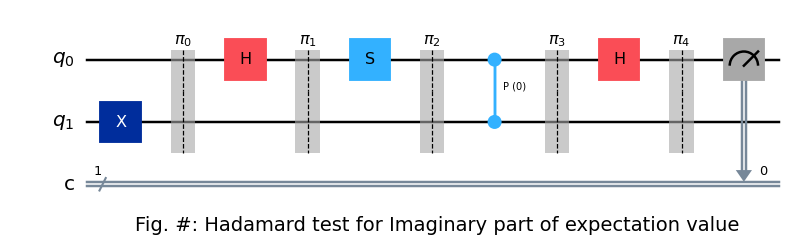

In [11]:
qc = im_circuit(0)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot()
ax.text(0, -2.75, 'Fig. #: Hadamard test for Imaginary part of expectation value', size=14)

qc.draw('mpl', ax=ax)

The approach to obtaining the imaginary part of the expectation value is almost exactly the same as the real part. This time, though, we will use the imaginary Hadamard test circuit which contains the addition of a phase gate $S = \begin{pmatrix} 1 & 0\\0 & i\end{pmatrix}$ on the control qubit. 

As we can see in $\text{Fig. \#}$, the first two states $|\pi_0\rangle$ and $|\pi_1\rangle$ are the same as for the real test.

$$|\pi_0\rangle = |0\rangle|\psi\rangle = \begin{pmatrix}1\\0\end{pmatrix}|\psi\rangle$$

$$|\pi_1\rangle = H|0\rangle|\psi\rangle = \frac{1}{\sqrt{2}}\begin{pmatrix} 1 & 1\\1 & -1\end{pmatrix}\begin{pmatrix}1\\0\end{pmatrix}|\psi\rangle = \frac{1}{\sqrt{2}}\begin{pmatrix} 1\\1 \end{pmatrix}|\psi\rangle = \frac{1}{\sqrt{2}}\left(|0\rangle + |1\rangle \right)|\psi\rangle = |+\rangle|\psi\rangle$$

Now the phase gate $S$ is applied to this state giving us the following

$$|\pi_2\rangle = S|+\rangle|\psi\rangle = \frac{1}{\sqrt{2}}\begin{pmatrix} 1 & 0\\0 & i\end{pmatrix}\begin{pmatrix} 1\\1\end{pmatrix}|\psi\rangle = \frac{1}{\sqrt{2}}\begin{pmatrix} (1\cdot 1) +  (0\cdot 1)\\(0\cdot 1) + (i\cdot 1)\end{pmatrix}|\psi\rangle = \frac{1}{\sqrt{2}}\begin{pmatrix} 1\\i\end{pmatrix}|\psi\rangle = \frac{1}{\sqrt{2}}\left(|0\rangle + i|1\rangle \right)|\psi\rangle$$

Performing the controlled-$U$ we get

$$|\pi_3\rangle = \frac{1}{\sqrt{2}}|0\rangle|\psi\rangle + \frac{1}{\sqrt{2}}i|1\rangle U|\psi\rangle = \frac{1}{\sqrt{2}}\begin{pmatrix} 1 & 0\\0 & e^{i\theta}\end{pmatrix}\begin{pmatrix} 1\\i\end{pmatrix}|\psi\rangle = \frac{1}{\sqrt{2}}\begin{pmatrix} (1\cdot 1) + (0\cdot i) \\(0\cdot 1) + (e^{i\theta}\cdot i)\end{pmatrix}|\psi\rangle = \frac{1}{\sqrt{2}}\begin{pmatrix} 1\\ie^{i\theta}\end{pmatrix}|\psi\rangle = \frac{1}{\sqrt{2}}(|0\rangle + ie^{i\theta}|1\rangle)|\psi\rangle$$

Lastly, we apply the second Hadamard gate to the state which gives

$$|\pi_4\rangle = H\frac{1}{\sqrt{2}}(|0\rangle + ie^{i\theta}|1\rangle)|\psi\rangle = \frac{1}{2}\begin{pmatrix} 1 & 1\\1 & -1\end{pmatrix}\begin{pmatrix} 1\\ie^{i\theta}\end{pmatrix}|\psi\rangle = \frac{1}{2}\begin{pmatrix} (1\cdot 1) + (1\cdot ie^{i\theta}) \\(1\cdot 1) + (-1\cdot ie^{i\theta})\end{pmatrix}|\psi\rangle = \frac{1}{2}\begin{pmatrix} 1 + ie^{i\theta} \\1 - ie^{i\theta}\end{pmatrix}|\psi\rangle = \left(\frac{1+ie^{i\theta}}{2}|0\rangle + \frac{1-ie^{i\theta}}{2}|1\rangle\right)|\psi\rangle$$

Similar to our analysis of the real test, this can also be written as the following

$$|0\rangle\frac{I+iU}{2}|\psi\rangle + |1\rangle\frac{I-iU}{2}|\psi\rangle$$

Using the same approach as before for calculating the probabilities, measuring qubit $0$ to be in the $|0\rangle$ state for the imaginary test we have

$$p_{\text{Im}}(|0\rangle) = \left||0\rangle\frac{I+iU}{2}|\psi\rangle\right|^2 = ||0\rangle|^2 \left|\frac{I+iU}{2}|\psi\rangle\right|^2 = \frac{\langle \psi|(I-iU^{\dagger})(I+iU)|\psi\rangle}{4} = \frac{\langle \psi|(I+iU-iU^{\dagger}+U^{\dagger}U)|\psi\rangle}{4}$$

And again for measuring qubit $0$ to be in the $|1\rangle$ state

$$p_{\text{Im}}(|1\rangle) = \left||0\rangle\frac{I-iU}{2}|\psi\rangle\right|^2 = ||0\rangle|^2 \left|\frac{I-iU}{2}|\psi\rangle\right|^2 = \frac{\langle \psi|(I+iU^{\dagger})(I-iU)|\psi\rangle}{4} = \frac{\langle \psi|(I-iU+iU^{\dagger}+U^{\dagger}U)|\psi\rangle}{4}$$

Following the same rules mentioned for the real test, if we subtract $p_0(|0\rangle)$ from $p_0(|1\rangle)$ we should be left with the imaginary part of the expectation value $\text{Im}\langle\psi|U|\psi\rangle$.

$$p_{\text{Im}}(|1\rangle) - p_{\text{Im}}(|0\rangle) = \frac{\langle \psi|(-iU+iU^{\dagger})|\psi\rangle}{2} = -i\frac{\langle \psi|U|\psi\rangle - \langle \psi|U^{\dagger}|\psi\rangle}{2} = \frac{2\text{Im}\langle\psi|U|\psi\rangle}{2} = \text{Im}\langle\psi|U|\psi\rangle$$

Just like with the real test, we can find the imaginary expectation value with just one of the probabilities as well

$$p_{\text{Im}}(|0\rangle) =  \frac{\langle \psi|(I+iU-iU^{\dagger}+U^{\dagger}U)|\psi\rangle}{4} = \frac{2+\langle \psi|iU|\psi\rangle-\langle \psi|iU^{\dagger}|\psi\rangle}{4} = \frac{1}{2}+i\frac{\langle \psi|U|\psi\rangle-\langle \psi|U^{\dagger}|\psi\rangle}{4} = \frac{1}{2}-
\frac{2\text{Im}\langle\psi|U|\psi\rangle}{4} = \frac{1}{2}(1 - \text{Im}\langle\psi|U|\psi\rangle)$$

$$p_{\text{Im}}(|1\rangle) =  \frac{\langle \psi|(I-iU+iU^{\dagger}+U^{\dagger}U)|\psi\rangle}{4} = \frac{2-\langle \psi|iU|\psi\rangle+\langle \psi|iU^{\dagger}|\psi\rangle}{4} = \frac{1}{2}-i\frac{\langle \psi|U|\psi\rangle-\langle \psi|U^{\dagger}|\psi\rangle}{4} = \frac{1}{2} + \frac{2\text{Im}\langle\psi|U|\psi\rangle}{4} = \frac{1}{2}(1 + \text{Im}\langle\psi|U|\psi\rangle)$$

Therefore, we can find the imaginary expectation value in the following three ways:

$$p_{\text{Im}}(|1\rangle) - p_{\text{Im}}(|0\rangle) = 1 - 2p_{\text{Im}}(|0\rangle) = 2p_{\text{Im}}(|1\rangle) - 1 =\text{Im}\langle\psi|U|\psi\rangle$$

By combining these real and imaginary results, we can estimate the expectation value $\langle\psi|U|\psi\rangle$.

Since we know our eigenvalue is $e^{i\theta}$, we can use Euler's formula to convert this to $\cos\theta + i\sin\theta$ where $\cos\theta$ is the real part and $\sin\theta$ is the imaginary part. Thus $\text{Re}\langle\psi|U|\psi\rangle = \cos\theta$ and $\text{Im}\langle\psi|U|\psi\rangle = \sin\theta$. So our real probabilities can be written as

$$p_{\text{Re}}(|0\rangle) = \frac{1}{2}(1+\text{Re}\langle\psi|U|\psi\rangle) = \frac{1}{2}(1+\cos\theta)$$

$$p_{\text{Re}}(|1\rangle) = \frac{1}{2}(1-\text{Re}\langle\psi|U|\psi\rangle) = \frac{1}{2}(1-\cos\theta)$$

Therefore $\theta$ can be estimated with the following

$$\theta \approx \arccos(2p_{\text{Re}}(|0\rangle) - 1) = \arccos(1 - 2p_{\text{Re}}(|1\rangle))$$

We can do the same with the imaginary part of Euler's formula and our expectation value:

$$p_{\text{Im}}(|0\rangle) = \frac{1}{2}(1-\text{Im}\langle\psi|U|\psi\rangle) = \frac{1}{2}(1-\sin\theta)$$

$$p_{\text{Im}}(|1\rangle) = \frac{1}{2}(1+\text{Im}\langle\psi|U|\psi\rangle) = \frac{1}{2}(1+\sin\theta)$$

Thus $\theta$ can also be estimated with the following

$$\theta \approx \arcsin(1 - 2p_{\text{Im}}(|0\rangle)) = \arcsin(2p_{\text{Im}}(|1\rangle) - 1)$$

PUT TANGENT PHASE ANGLE FINDING AS WELL. COMPLEX UNIT CIRCLE EXAMPLE.

Let's run the circuits and see what we get:

### Verification

In [14]:
angle = 0.5625 #Exact value of phi to estimate

In [15]:
def re_circuit(theta):
    circuit = QuantumCircuit(2,1) #Create circuit with 2 qubits and 1 classical bit
    circuit.x(1) #Apply pauli-x gate to q1 to put it to 1 state
    circuit.barrier(label='$π_0$')    
    circuit.h(0) #Apply hadamard gate to q0 to put it into + state
    circuit.barrier(label='$π_1$') 
    circuit.cp(theta,0,1) # rotates q0 2*pi*theta radians if q1 is 1
    circuit.barrier(label='$π_2$') 
    circuit.h(0) #Apply second hadamard gate to q0 to ensure the value phi affects our output
    circuit.barrier(label='$π_3$')
    circuit.measure(0,0) #Measure q0
    return circuit

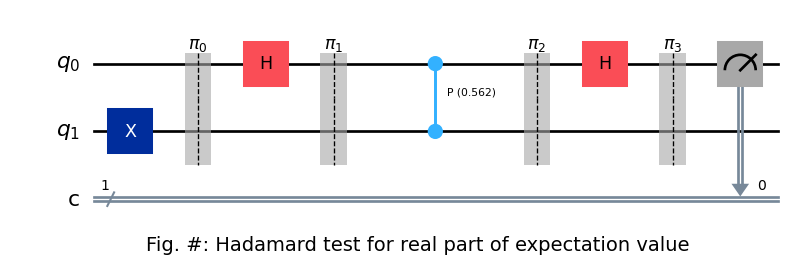

In [16]:
qc = re_circuit(angle)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot()
ax.text(0, -2.75, 'Fig. #: Hadamard test for real part of expectation value', size=14)

qc.draw('mpl', ax=ax)

In [18]:
def im_circuit(theta):
    circuit = QuantumCircuit(2,1) #Create circuit with 2 qubits and 1 classical bit
    circuit.x(1) #Apply pauli-x gate to q1 to put it to 1 state
    circuit.barrier(label='$π_0$')
    circuit.h(0) #Apply hadamard gate to q0 to put it into + state
    circuit.barrier(label='$π_1$')
    circuit.s(0) #Apply phase gate to make imaginary
    circuit.barrier(label='$π_2$')
    circuit.cp(theta,0,1) #Rotates q0 2*pi*theta radians if q1 is 1
    circuit.barrier(label='$π_3$')
    circuit.h(0) #Apply second hadamard gate to q0 to ensure the value phi affects our output
    circuit.barrier(label='$π_4$')
    circuit.measure(0,0) #Measure q0
    return circuit

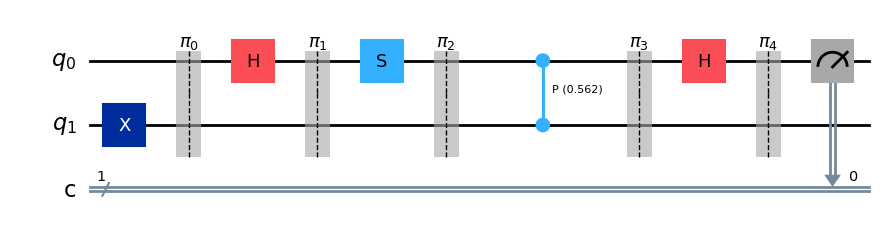

In [19]:
qc2 = im_circuit(angle)
qc2.draw("mpl")

In [9]:
backend = BasicSimulator()

num_of_shots = 10000

re_result = backend.run(qc, shots=num_of_shots).result()   
re_counts = re_result.get_counts()                    

im_result = backend.run(qc2, shots=num_of_shots).result()   
im_counts = im_result.get_counts()                

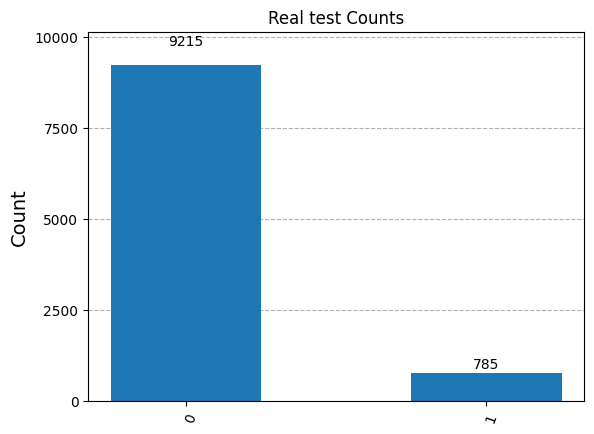

In [11]:
plot_histogram(re_counts, title = 'Real test Counts')

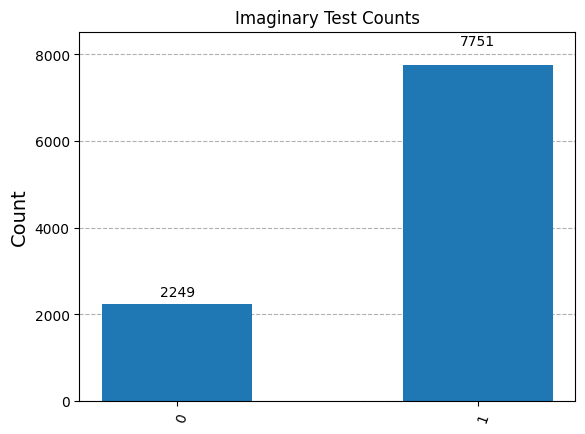

In [12]:
plot_histogram(im_counts, title = 'Imaginary Test Counts')

Using our computed equations for the measured probabilities $p_{\text{Re}}(|0\rangle)$ and $p_{\text{Re}}(|1\rangle)$, we can check that they match what we get from running the circuit.

$$p_{\text{Re}}(|0\rangle) = \frac{1}{2}(1+\cos\theta) = \frac{1}{2}(1+\cos(0.5625)) \approx 0.9230$$

$$p_{\text{Re}}(|1\rangle) = \frac{1}{2}(1-\cos\theta) = \frac{1}{2}(1-\cos(0.5625)) \approx 0.0770$$

Comparing this to the probabilites from the circuit, we can see they are very close to what we expect so we can say they do indeed match.

$$p_{\text{Re}}(|0\rangle) = 0.9212$$

$$p_{\text{Re}}(|1\rangle) = 0.0788$$

We can again do the same for the imaginary circuit where our computer probabilites are as follows

$$p_{\text{Im}}(|0\rangle) = \frac{1}{2}(1-\sin\theta) = \frac{1}{2}(1-\sin(0.5625)) \approx 0.2333$$

$$p_{\text{Im}}(|1\rangle) = \frac{1}{2}(1+\sin\theta) = \frac{1}{2}(1+\sin(0.5625)) \approx 0.7667$$

And comparing these to the probabilities from the circuit we again see that they are very close and matchup.

$$p_{\text{Im}}(|0\rangle) = 0.23411$$

$$p_{\text{Im}}(|1\rangle) = 0.76589$$


In [13]:
print('For Real Part:\nCalculated probability of measuring 0: ',0.5*(1 + np.cos(angle)))
print('Calculated probability of measuring 1: ', 0.5*(1 - np.cos(angle)))

print('Probability of measuring 0', re_counts['0']/num_of_shots)
print('Probability of measuring 1', re_counts['1']/num_of_shots)

print('\nFor Imaginary Part:\nCalculated probability of measuring 0: ',0.5*(1 - np.sin(angle)))
print('Calculated probability of measuring 1: ', 0.5*(1 + np.sin(angle)))

print('Probability of measuring 0', im_counts['0']/num_of_shots)
print('Probability of measuring 1', im_counts['1']/num_of_shots)

For Real Part:
Calculated probability of measuring 0:  0.922962249615534
Calculated probability of measuring 1:  0.07703775038446603
Probability of measuring 0 0.9215
Probability of measuring 1 0.0785

For Imaginary Part:
Calculated probability of measuring 0:  0.23334866323198994
Calculated probability of measuring 1:  0.7666513367680101
Probability of measuring 0 0.2249
Probability of measuring 1 0.7751


We can also clearly see that these probabilities both sum to $1$ which is what we expect. If we cycle through values of $\theta$ from $0\text{ rad}$ to $2\pi\text{ rad}$ and plot the probabilities of measuring $|1\rangle$ or $|0\rangle$, we can see that they always sum to 1.

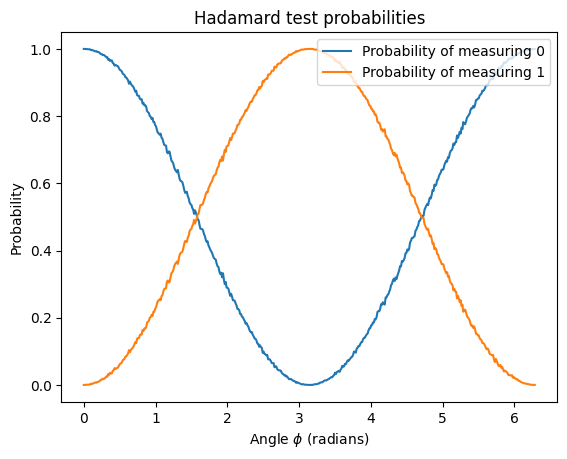

In [14]:
backend = BasicSimulator()

angles = np.linspace(0, 2*pi, 500)
prob0 = []
prob1 = []
expected_phi = angles
for ang in angles:
    circ = re_circuit(ang)
    num_of_shots = int(num_of_shots)
    counts = backend.run(circ, shots=num_of_shots).result().get_counts()
    prob0val = counts.get('0')
    prob1val = counts.get('1')
    if prob0val is not None and prob1val is not None:        
        prob0.append(counts['0']/num_of_shots)
        prob1.append(counts['1']/num_of_shots)
    elif prob0val is None:
        prob0.append(0)
        prob1.append(counts['1']/num_of_shots)
    elif prob1val is None:
        prob1.append(0)
        prob0.append(counts['0']/num_of_shots)
plt.plot(angles, prob0, label = 'Probability of measuring 0')
plt.plot(angles, prob1, label = 'Probability of measuring 1')
plt.xlabel('Angle $\phi$ (radians)')
plt.ylabel('Probability')
plt.title('Hadamard test probabilities')
plt.legend(loc = 'upper right')
plt.show()

justification of subtracting both the probablities

In [15]:
print("Results of the Trial: ")
print("  Real Circuit:  \t",re_counts)
print("  Imginary Circuit:\t",im_counts)

re_p0 = re_counts['0']/num_of_shots
re_p1 = re_counts['1']/num_of_shots
im_p0 = im_counts['0']/num_of_shots
im_p1 = im_counts['1']/num_of_shots

re = re_p0 - re_p1
#re = 2*(re_p0) - 1
#re = 1 - 2*(re_p1)

im = im_p1 - im_p0
#im = 1 - 2*(im_p0)
#im = 2*(im_p1) - 1

ans = np.arcsin(im)
#ans = np.arccos(re)
#ans = np.arctan(im/re)

print("\nWhat we got: ", ans)
print("What we want: ", angle)

Results of the Trial: 
  Real Circuit:  	 {'0': 9215, '1': 785}
  Imginary Circuit:	 {'0': 2249, '1': 7751}

What we got:  0.5826037304932812
What we want:  0.5625


graph explainination(error)

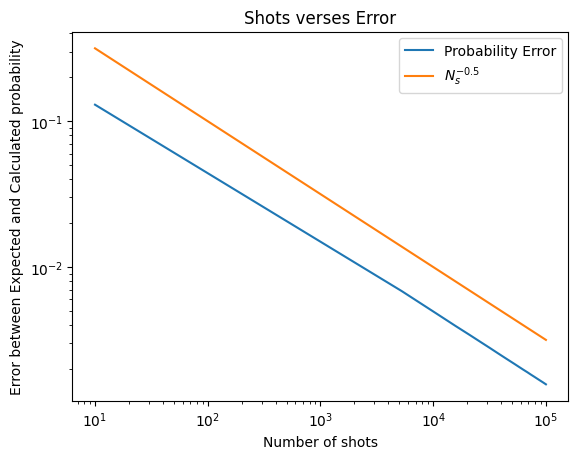

In [16]:
# Construct a graph of error verses number of shots
backend = BasicSimulator()

trials = np.linspace(10, 10**5, 20)
Ns = []
error_diff = []
for num_of_shots in trials:
    # for some reason python doesn't believe this number is an integer
    num_of_shots = int(num_of_shots)
    re_counts = backend.run(qc, shots=num_of_shots).result().get_counts() 
    im_counts = backend.run(qc2, shots=num_of_shots).result().get_counts() 

    re_p0 = re_p1 = im_p0 = im_p1 = 0
    
    if re_counts.get('0') is not None:
        re_p0 = re_counts['0']/num_of_shots
        
    if re_counts.get('1') is not None:
        re_p1 = re_counts['1']/num_of_shots
        
    if im_counts.get('0') is not None:
        im_p0 = im_counts['0']/num_of_shots
        
    if im_counts.get('1') is not None:
        im_p1 = im_counts['1']/num_of_shots

    
    re = re_p0 - re_p1
    im = im_p1 - im_p0
    ans = np.arctan(im/re)
    
    error_diff.append( (ans*(1 - ans)/num_of_shots)**(0.5) )
    Ns.append( num_of_shots**(-0.5) )
    
plt.loglog(trials, error_diff, label = 'Probability Error')
plt.loglog(trials, Ns, label = '$N_s^{-0.5}$')
plt.title("Shots verses Error")
plt.xlabel("Number of shots")
plt.ylabel("Error between Expected and Calculated probability")
plt.legend(loc='upper right')
plt.show()